In [5]:
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import csv

In [6]:
class hp:
    def nu_func(length):
        return 299792.458/length 

    def grey(length, norm, temp, beta):
        nu = hp.nu_func(length)
        lum = (norm*(nu**(3 + beta)))/(np.exp(0.048*nu/temp) - 1)
        return lum
    
    def fitting(lens_def, flux_def, temp, beta):
        norm = 0.05
        norm_max = 5
        step = 0.01
        sum = []
        norms = []
        while norm < norm_max:
            flux_calc = hp.grey(lens_def, norm*10**(-15), temp, beta)
            delta = (flux_def - flux_calc)**2
            sum.append(np.sum(delta))
            norms.append(norm)
            norm += step
        ind = sum.index(min(sum))
        return norms[ind]
#
#    def fitter(x, y, temp, nu, beta):
#        norm = 0.01
#        step = 0.01
#        ls = [hp.grey(norm, temp, nu, beta), hp.grey(norm+step, temp, nu, beta)]
#        for i in range(2, 10000):
#            norm = step*(i+1)
#            y_0 = []
#            for item in x:
#                y_0.append(hp.grey(norm, temp, ))
    
    def len_func(nu):
        return 299792.458/nu

class Main(hp):
    def __init__(self, file_csv, file_json):
        self.file_csv = file_csv
        self.file_json = file_json

        self.base_json = []
        self.base_csv = []
    
    def json_reader(self):
        f = open(self.file_json)
        self.base_json = json.load(f)
        f.close()
    
    def csv_reader(self):
        with open(self.file_csv, encoding='utf-8') as csvfile:
            reader_sn = csv.DictReader(csvfile)
            for row in reader_sn:
                self.base_csv.append(
                    {
                    'OI' : row['OI'],
                    'ID' : row['ID'],
                    'Fint' : float(row['Fint']),
                    'eFint' : float(row['eFint']),
                    'S12' : float(row['S12']),
                    'S25': float(row['S25']),
                    'S60' : float(row['S60']),
                    'S100' : float(row['S100']),
                    'F100' : float(row['F100']),
                    'E100' : float(row['E100']),
                    'F160' : float(row['F160']),
                    'E160' : float(row['E160']),
                    'F250' : float(row['F250']),
                    'E250' : float(row['E250']),
                    'F350' : float(row['F350']),
                    'E350' : float(row['E350']),
                    'F500' : float(row['F500']),
                    'E500' : float(row['E500']),
                    'Td' : float(row['Td'])
                    })
    
    def updater(self):
        for i in range(len(self.base_csv)):
            self.base_csv[i].update({'F2650' : float(self.base_json[i]['flux_0_c'])})
            self.base_csv[i].update({'E2650' : float(self.base_json[i]['flux_0_c_er'])})
            self.base_csv[i].update({'flux_0' : float(self.base_json[i]['flux_0'])})
            self.base_csv[i].update({'flux_0_er' : float(self.base_json[i]['flux_0_er'])})
        print(self.base_csv)
    
    def phot_builder(self):
        for flux in self.base_csv:
            fig = plt.figure()
            ax = fig.add_subplot()
            S_length = [12, 25, 60] #100
            flux_def = []
            lens_def  = []
            S = [flux['S12'], flux['S25'], flux['S60']] #flux['S100']
            for i in range(len(S)):
                if S[i] > 0:
                    flux_def.append(S[i])
                    lens_def.append(S_length[i])
                    ax.errorbar(S_length[i], S[i], xerr=0, yerr=0, fmt = 'o', c='r')
                    ax.text(S_length[i], S[i], str(S_length[i]))
            
            F_length = [100, 160, 250, 350, 500, 2650]
            F = [flux['F100'], flux['F160'], flux['F250'], flux['F350'], flux['F500'], flux['F2650']]
            E = [flux['E100'], flux['E160'], flux['E250'], flux['E350'], flux['E500'], flux['E2650']]

            for i in range(len(F)):
                if F[i] > 0:
                    flux_def.append(F[i])
                    lens_def.append(F_length[i])
                    ax.errorbar(F_length[i], F[i], xerr=0, yerr=E[i], fmt = 'o')
                    ax.text(F_length[i], F[i], str(F_length[i]))
            
            #finding normalization
            lens_def = np.array(lens_def)
            flux_def - np.array(flux_def)
            len_min = 10
            len_max = 2700

            norm = hp.fitting(lens_def, flux_def, flux['Td'], 2)

            lens = np.arange(len_min, len_max, 5)
            fluxes = hp.grey(lens, norm*10**(-15), flux['Td'], 2)

            ax.plot(lens, fluxes)

            textstr = '\n'.join((
            r'$\mathrm{norm}=%.2e$' % (norm*10**(-15), ),
            r'$\mathrm{T_d}=%.2f$' % (flux['Td'], ),
            r'$\beta=%.2f$' % (2, )))
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top')
        
            ax.set_xscale('log')
            ax.set_xlabel('wavelength, mkm')
            ax.set_ylabel('flux, Jy')
            ax.set_title(f"{flux['OI']} ({flux['ID']})")
            name = 'PLOTS/' + flux['OI'] + '_photo.png'
            
            plt.savefig(name)

    def flux_builder(self):
        fig = plt.figure()
        ax = fig.add_subplot()
        for flux in self.base_csv:
            if flux['flux_0'] > 0:
                if float(flux['OI']) <= 3:
                    ax.errorbar(flux['Fint'], flux['flux_0'], xerr=flux['eFint'], yerr=flux['flux_0_er'], fmt = 'o', c='r')
                    ax.text(flux['Fint'], flux['flux_0'], flux['OI'])
                if 3 < float(flux['OI']) < 11:
                    ax.errorbar(flux['Fint'], flux['flux_0'], xerr=flux['eFint'], yerr=flux['flux_0_er'], fmt = 'o', c='g')
                    ax.text(flux['Fint'], flux['flux_0'], flux['OI'])
                if float(flux['OI']) >= 11:
                    ax.errorbar(flux['Fint'], flux['flux_0'], xerr=flux['eFint'], yerr=flux['flux_0_er'], fmt = 'o', c='c')
                    ax.text(flux['Fint'], flux['flux_0'], flux['OI'])

        ax.errorbar(-99.9,-99.9, label='Componented', color='r', fmt = 'o')
        ax.errorbar(-99.9,-99.9, label='Super-AGN', color='c', fmt = 'o')
        ax.errorbar(-99.9,-99.9, label='Far-faint', color='g', fmt = 'o')

        ax.legend()
    
        ax.plot([0,20],[0,20], 'c--')
        ax.set_xlim([0,12.5])
        ax.set_ylim([0,12.5])
        ax.set_xlabel('Fint, Jy or Jy.km/s?')
        ax.set_ylabel('Flux_mom0, Jy.km/s')
        plt.savefig('PLOTS/FLUX.png')
    


[{'OI': '1', 'ID': 'J091205.8+002656', 'Fint': 10.463904381, 'eFint': 1.3826662302, 'S12': 0.10499999672, 'S25': 0.15000000596, 'S60': 0.79600000381, 'S100': 1.1859999895, 'F100': 1.0965774059, 'E100': 0.026287019253, 'F160': 0.90946424007, 'E160': 0.026287019253, 'F250': 0.37509444, 'E250': 0.011489476, 'F350': 0.15139734857, 'E350': 0.0081090077629, 'F500': 0.054754694621, 'E500': 0.0094125619161, 'Td': 24.100000381, 'F2650': 0.000225067, 'E2650': 2.99285e-05, 'flux_0': 8.58693, 'flux_0_er': 0.1532517}, {'OI': '2', 'ID': 'J091448.7-003533', 'Fint': 6.9391460419, 'eFint': 1.3149862289, 'S12': -99.0, 'S25': -99.0, 'S60': -99.0, 'S100': -99.0, 'F100': 0.33443325758, 'E100': 0.029837841168, 'F160': 0.41142034531, 'E160': 0.029837841168, 'F250': 0.25, 'E250': 0.015483253, 'F350': 0.108, 'E350': 0.015375453, 'F500': 0.028621, 'E500': 0.009141, 'Td': 21.5, 'F2650': 0.000139191, 'E2650': 7.96347e-05, 'flux_0': 5.18085, 'flux_0_er': 0.4738956}, {'OI': '3', 'ID': 'J085828.5+003814', 'Fint': 6.

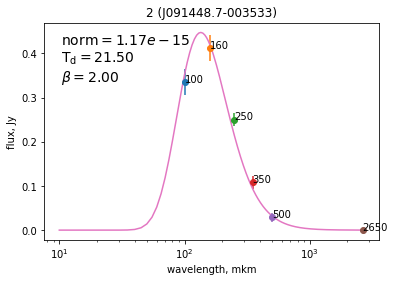

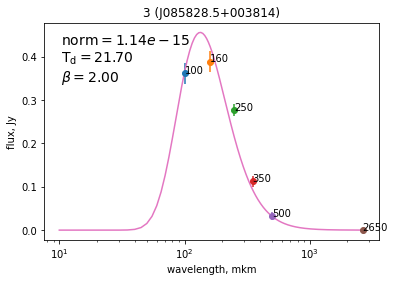

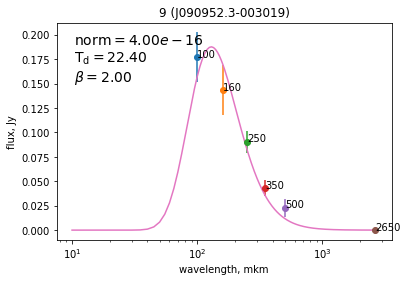

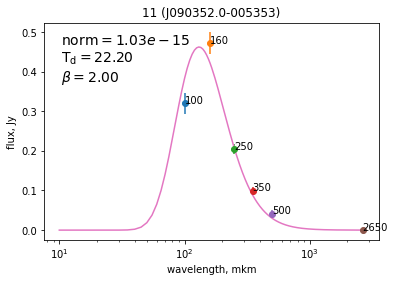

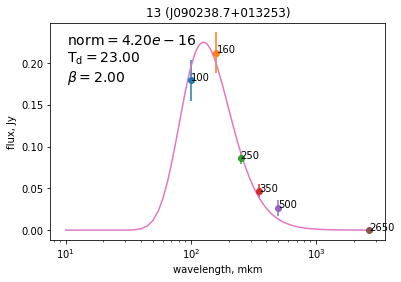

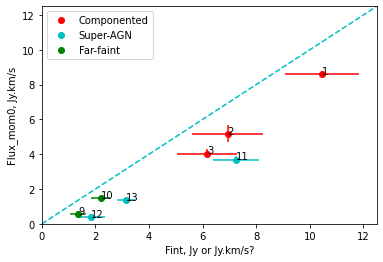

In [7]:
if __name__ == '__main__':
    obj = Main('table_my.csv', 'RG.json')
    obj.json_reader()
    obj.csv_reader()
    obj.updater()
    obj.phot_builder()
    obj.flux_builder()